In [60]:
import pandas as pd
from datetime import date  # Not heavily used here, but for any date ops
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline
# Load the datasets 
train_df = pd.read_csv('train.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [61]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [62]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [63]:
df = (train_df.merge(stores_df, on='Store', how='left')
      .merge(features_df, on=['Store', 'Date'], how='left'))

In [64]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
dtype: int64

In [65]:
# Markdowns: Fill NaN with 0 
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)
df['IsHoliday_x'] = df['IsHoliday_x'].astype(bool)
df['CPI'] = df['CPI'].fillna(method='ffill')
df['Unemployment'] = df['Unemployment'].fillna(method='ffill')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False


In [66]:
# Feature engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['DayOfYear'] = df['Date'].dt.dayofyear
df['IsHoliday_x'] = df['IsHoliday_x'].astype(int)
df.drop(columns=['IsHoliday_y'], inplace=True)
#Log-transform sales
df['Weekly_Sales_Log'] = np.log1p(df['Weekly_Sales'])  # log(1 + x)
df = df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

In [67]:
print("Dataset shape:", df.shape)
print("\nDate range:", df['Date'].min(), "to", df['Date'].max())
print("\nMissing values after filling:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# How many weeks per store-dept?
weeks_per_series = df.groupby(['Store', 'Dept']).size()
print(f"\nWeeks per (Store, Dept) - min: {weeks_per_series.min()}, max: {weeks_per_series.max()}, median: {weeks_per_series.median()}")

# Top departments by total sales
print("\nTop 10 departments by total sales:")
print(df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(10))

Dataset shape: (421570, 21)

Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00

Missing values after filling:
Weekly_Sales_Log    1225
dtype: int64

Weeks per (Store, Dept) - min: 1, max: 143, median: 143.0

Top 10 departments by total sales:
Dept
92    4.839433e+08
95    4.493202e+08
38    3.931181e+08
72    3.057252e+08
90    2.910685e+08
40    2.889360e+08
2     2.806112e+08
91    2.167817e+08
13    1.973216e+08
8     1.942808e+08
Name: Weekly_Sales, dtype: float64


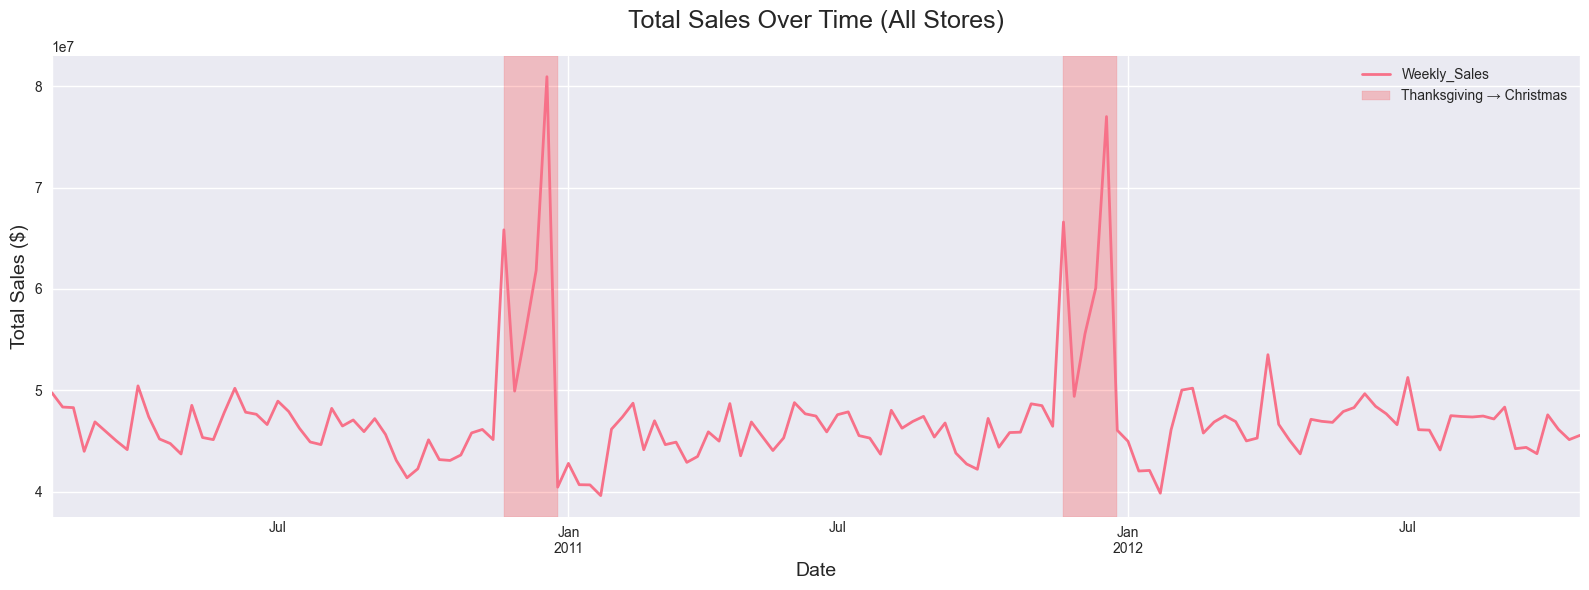

In [68]:
# Total Sales Over Time
plt.figure(figsize=(16,6))
df.groupby('Date')['Weekly_Sales'].sum().plot(linewidth=2)
plt.title('Total Sales Over Time (All Stores)', fontsize=18, pad=20)
plt.ylabel('Total Sales ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.axvspan('2010-11-26', '2010-12-30', color='red', alpha=0.2, label='Thanksgiving → Christmas')
plt.axvspan('2011-11-25', '2011-12-30', color='red', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

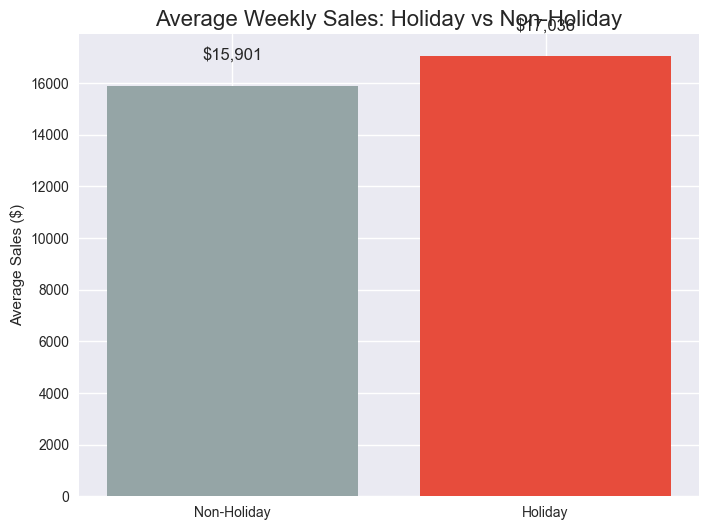

In [72]:
#Holiday vs Non-Holiday Sales
holiday_sales = df.groupby('IsHoliday_x')['Weekly_Sales'].mean()
plt.figure(figsize=(8,6))
bars = plt.bar(['Non-Holiday', 'Holiday'], holiday_sales, color=['#95a5a6', '#e74c3c'])
plt.title('Average Weekly Sales: Holiday vs Non-Holiday', fontsize=16)
plt.ylabel('Average Sales ($)')
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'${height:,.0f}', ha='center', fontsize=12)
plt.show()



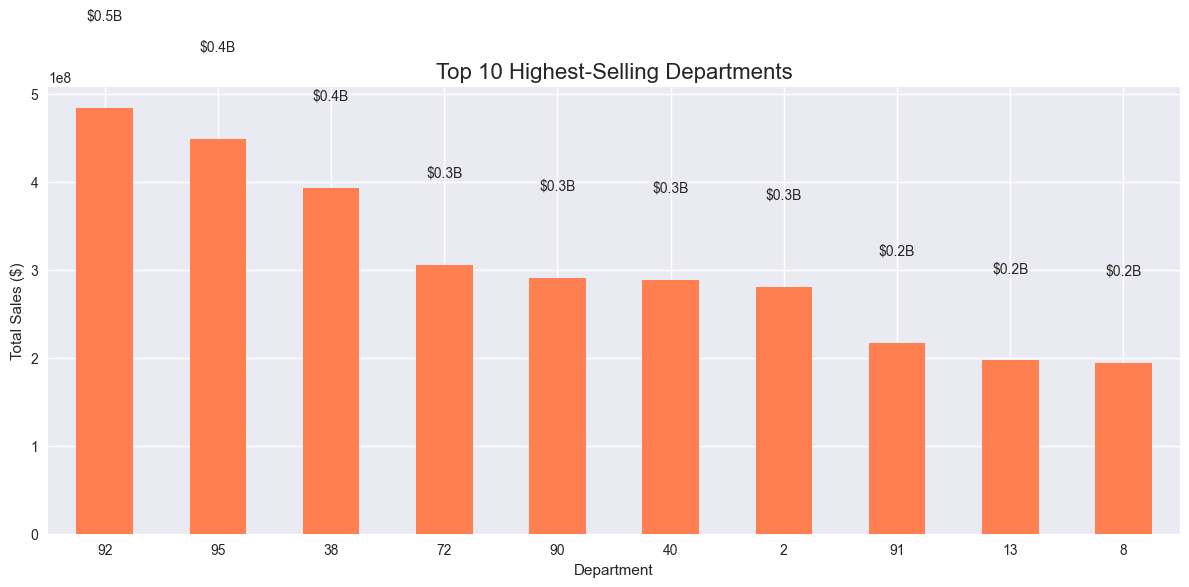

In [73]:
# Top 10 Departments by Sales
top_depts = df.groupby('Dept')['Weekly_Sales'].sum().nlargest(10)

plt.figure(figsize=(12,6))
top_depts.plot(kind='bar', color='coral')
plt.title('Top 10 Highest-Selling Departments', fontsize=16)
plt.ylabel('Total Sales ($)')
plt.xlabel('Department')
plt.xticks(rotation=0)
for i, v in enumerate(top_depts):
    plt.text(i, v + 1e8, f"${v/1e9:.1f}B", ha='center')
plt.tight_layout()
plt.show()

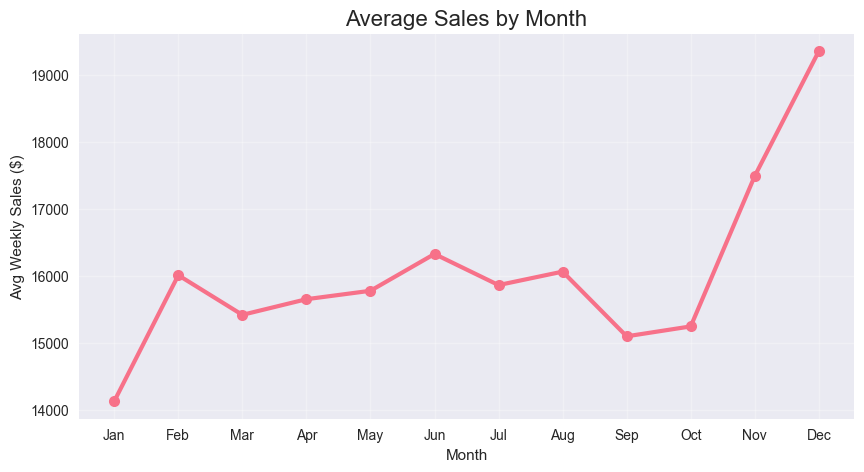

In [74]:
#  Seasonality - Monthly Pattern
monthly = df.groupby(df['Date'].dt.month)['Weekly_Sales'].mean()
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(10,5))
plt.plot(months, monthly.values, marker='o', linewidth=3, markersize=8)
plt.title('Average Sales by Month', fontsize=16)
plt.ylabel('Avg Weekly Sales ($)')
plt.xlabel('Month')
plt.grid(True, alpha=0.3)
plt.show()

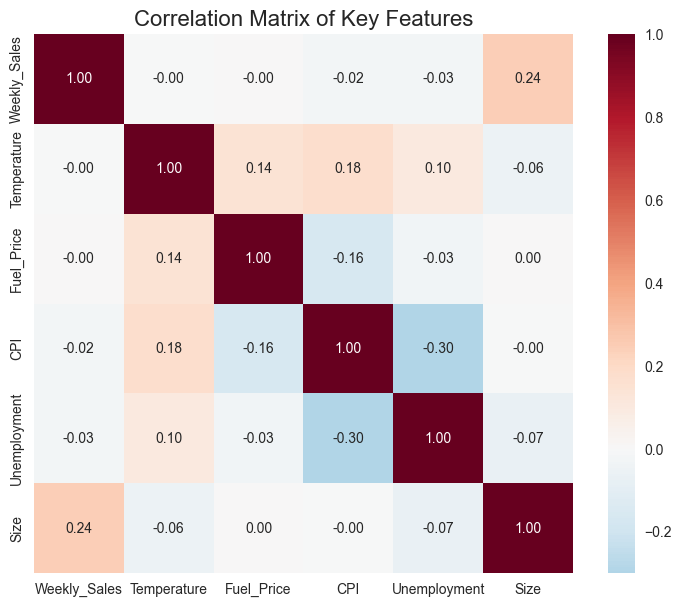

In [75]:
# Temperature and Fuel Price vs Sales Heatmap
corr_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
corr = df[corr_features].corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, square=True, fmt='.2f')
plt.title('Correlation Matrix of Key Features', fontsize=16)
plt.show()

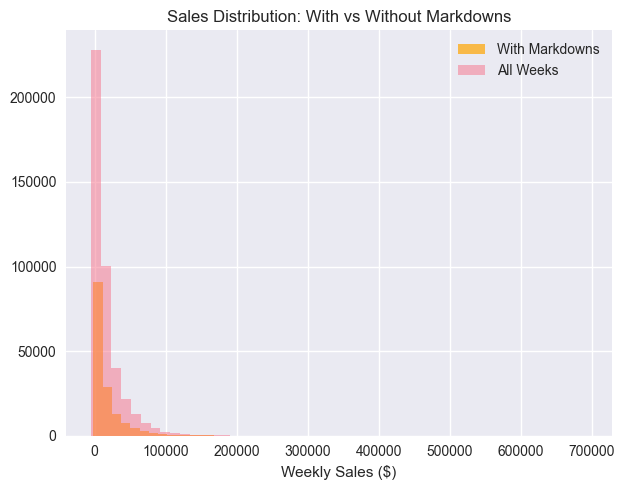

In [76]:
# Markdown Impact
markdown_weeks = df[(df[markdown_cols] > 0).any(axis=1)]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
markdown_weeks['Weekly_Sales'].hist(bins=50, alpha=0.7, label='With Markdowns', color='orange')
df['Weekly_Sales'].hist(bins=50, alpha=0.5, label='All Weeks')
plt.title('Sales Distribution: With vs Without Markdowns')
plt.xlabel('Weekly Sales ($)')
plt.legend()
plt.tight_layout()
plt.show()